# **Parseval Network**

# **Data Preparation**

In [0]:
from sklearn.model_selection import train_test_split
import gzip
import pickle
import numpy as np

In [0]:
def read_data():
    with open("data.pz", 'rb') as file_:
        with gzip.GzipFile(fileobj=file_) as gzf:
            data = pickle.load(gzf, encoding='latin1', fix_imports=True)
    return data
data = read_data()
new_data_X = []
Y_data = []
for row in data:
    new_data_X.append(row['crop'])
    Y_data.append(row['label'])
new_data_X = np.array(new_data_X)
new_data_X.shape

(5722, 68, 100)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(new_data_X, Y_data, test_size=0.33, random_state=42)

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# creating initial dataframe

y_train_df = pd.DataFrame(y_train, columns=['Label'])
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
y_train_df['New'] = labelencoder.fit_transform(y_train_df['Label'])
y_test_df = pd.DataFrame(y_test, columns=['Label'])
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
y_test_df['New'] = labelencoder.fit_transform(y_test_df['Label'])

In [0]:
from keras import backend as K
img_rows, img_cols = X_train[0].shape


# transform data set
if K.common.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Using TensorFlow backend.


# Othogonal Constraint

In [0]:
from tensorflow.python.keras.constraints import Constraint
from tensorflow.python.ops import math_ops, array_ops

class TightFrame(Constraint):


    def __init__(self, scale, num_passes=1):
        self.scale = scale

        if num_passes < 1:
            raise ValueError("Number of passes cannot be non-positive! (got {})".format(num_passes))
        self.num_passes = num_passes


    def __call__(self, w):
        transpose_channels = (len(w.shape) == 4)

        # Move channels_num to the front in order to make the dimensions correct for matmul
        if transpose_channels:
            w_reordered = array_ops.reshape(w, (-1, w.shape[0]))

        else:
            w_reordered = w

        last = w_reordered
        for i in range(self.num_passes):
            temp1 = math_ops.matmul(last, last, transpose_a=True)
            temp2 = (1 + self.scale) * w_reordered - self.scale * math_ops.matmul(w_reordered, temp1)

            last = temp2

        # Move channels_num to the back again
        if transpose_channels:
            return array_ops.reshape(last, w.shape)
        else:
            return last


    def get_config(self):
        return {'scale': self.scale, 'num_passes': self.num_passes}


# Alias
tight_frame = TightFrame

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import warnings

warnings.filterwarnings("ignore")
weight_decay = 0.0005


**Parseval Network**

In [0]:


def initial_conv(input):
  
    x = Convolution2D(16, (3, 3), padding='same', kernel_initializer='orthogonal', kernel_constraint= tight_frame(0.0001),
                      
                      use_bias=False)(input)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    return x


def expand_conv(init, base, k, strides=(1, 1)):
    x = Convolution2D(base * k, (3, 3), padding='same', strides=strides, kernel_initializer='Orthogonal', kernel_constraint= tight_frame(0.0001),
                      use_bias=False)(init)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = Convolution2D(base * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_constraint= tight_frame(0.0001),
                      use_bias=False)(x)

    skip = Convolution2D(base * k, (1, 1), padding='same', strides=strides, kernel_initializer='Orthogonal',
                      kernel_constraint= tight_frame(0.0001),
                      use_bias=False)(init)

    m = Add()([x, skip])

    return m


def conv1_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_constraint= tight_frame(0.0001),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_constraint= tight_frame(0.0001),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    print("conv2:channel:  {}".format(channel_axis))
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_constraint= tight_frame(0.0001),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_constraint= tight_frame(0.0001),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    print("conv3 channel_axis:{} ".format(channel_axis))
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_constraint= tight_frame(0.0001),use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_constraint= tight_frame(0.0001),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def create_parseval_network(input_dim, nb_classes=100, N=2, k=1, dropout=0.0, verbose=1):
    """
    Creates a Wide Residual Network with specified parameters

    :param input: Input Keras object
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    :param verbose: Debug info to describe created WRN
    :return:
    """
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    ip = Input(shape=input_dim)

    x = initial_conv(ip)
    nb_conv = 4

    x = expand_conv(x, 16, k)
    nb_conv += 2

    for i in range(N - 1):
        x = conv1_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 32, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv2_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 64, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv3_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)

    x = Dense(nb_classes, activation='softmax' )(x)

    model = Model(ip, x)

    if verbose: print("Parseval Residual Network-%d-%d created." % (nb_conv, k))
    return model

if __name__ == "__main__":

    init = (68, 100,1)

    parseval_16_2 = create_parseval_network(init, nb_classes=4, N=2, k=2, dropout=0.3)

conv2:channel:  -1
conv3 channel_axis:-1 
Parseval Residual Network-16-2 created.


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.callbacks as callbacks


In [0]:
EPOCHS = 200
BS = 128


In [0]:
from tensorflow.keras.callbacks import LearningRateScheduler
import math
from tensorflow.keras.optimizers import SGD

sgd = SGD(lr=0.1, momentum=0.9)

In [0]:
parseval_16_2.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
print("Finished compiling")

Finished compiling


In [0]:
import tensorflow
generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                               width_shift_range=5./32,
                               height_shift_range=5./32,)

In [0]:
def lr_sch(epoch):
    if epoch < 60:
        return 0.1
    elif epoch < 120:
        return 0.02
    elif epoch < 160:
        return 0.004
    else:
        return 0.0008

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_sch)

In [0]:
from tensorflow.keras.utils import to_categorical
hist = parseval_16_2.fit(generator.flow(X_train, to_categorical(y_train_df['New']), batch_size=BS), steps_per_epoch=len(X_train) // BS, epochs=EPOCHS,
                   validation_data=(X_test, to_categorical(y_test_df['New'])), callbacks = [lr_scheduler],
                   validation_steps=X_test.shape[0] // BS,)

Epoch 1/200
29/29 [==============================] - 13s 439ms/step - loss: 1.3324 - acc: 0.3406 - val_loss: 1.5744 - val_acc: 0.2912 - lr: 0.1000
Epoch 2/200
29/29 [==============================] - 10s 357ms/step - loss: 1.2603 - acc: 0.3970 - val_loss: 1.2040 - val_acc: 0.4415 - lr: 0.1000
Epoch 3/200
29/29 [==============================] - 10s 358ms/step - loss: 1.2331 - acc: 0.4227 - val_loss: 1.2220 - val_acc: 0.4352 - lr: 0.1000
Epoch 4/200
29/29 [==============================] - 10s 355ms/step - loss: 1.2114 - acc: 0.4459 - val_loss: 1.1742 - val_acc: 0.4600 - lr: 0.1000
Epoch 5/200
29/29 [==============================] - 10s 359ms/step - loss: 1.1638 - acc: 0.4696 - val_loss: 1.7581 - val_acc: 0.3695 - lr: 0.1000
Epoch 6/200
29/29 [==============================] - 10s 359ms/step - loss: 1.1504 - acc: 0.4947 - val_loss: 1.0782 - val_acc: 0.5437 - lr: 0.1000
Epoch 7/200
29/29 [==============================] - 10s 357ms/step - loss: 1.0985 - acc: 0.5285 - val_loss: 1.1574 - 

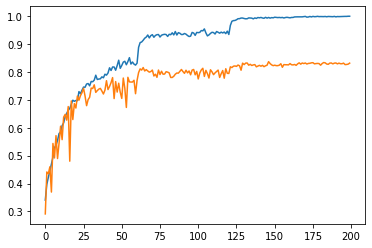

In [0]:
from matplotlib import  pyplot

pyplot.plot(hist.history["acc"], label='train')
pyplot.plot(hist.history['val_acc'], label='test')


In [0]:
test_err = [1.0-x for x in hist.history['val_acc']]

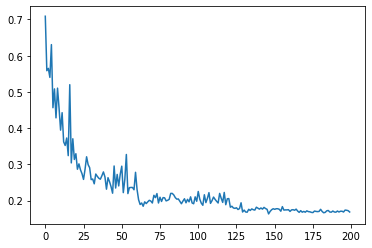

In [0]:
pyplot.plot(test_err, label='test')
pyplot.savefig("deneme_err.png")

In [0]:
import tensorflow as tf
parseval_16_2.save("parseval_tensor_lst.h5")

In [0]:
y_pred = parseval_16_2.predict(X_test)

In [0]:
parseval_16_2.evaluate(X_test,to_categorical(y_test_df['New']),batch_size=128,verbose=2)

15/15 - 1s - loss: 0.8171 - acc: 0.8317


[0.817147433757782, 0.8316569328308105]

In [0]:
!pip install -q tensorflow==2.0.0b1
# Install bleeding edge version of cleverhans
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

import cleverhans
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

     |████████████████████████████████| 87.9MB 35kB/s 
     |████████████████████████████████| 3.1MB 52.2MB/s 
     |████████████████████████████████| 501kB 56.3MB/s 
  Cloning https://github.com/tensorflow/cleverhans.git to /tmp/pip-install-nh_dsdoh/cleverhans
  Running command git clone -q https://github.com/tensorflow/cleverhans.git /tmp/pip-install-nh_dsdoh/cleverhans
     |████████████████████████████████| 163kB 31.1MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
  Created wheel for cleverhans: filename=cleverhans-3.0.1-cp36-none-any.whl size=262572 sha256=708b7304ac7a6e28e4ef9ea44126f4a715f8f96b8ee650c8814df301078e521a
  Stored in directory: /tmp/pip-ephem-wheel-cache-jif2zqq_/wheels/6e/59/ec/723a6f654aaf62c8c40f0f0850fdf71a4948598697f56c3bfa
Successfully built cleverhans

Tensorflow Version: 2.2.0
Cleverhans Version: 3.0.1-fc7b7c7ec903258e0e3fb88503fa629f
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True


In [0]:
from cleverhans.future.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(wrn_28_10.input,wrn_28_10.layers[-1].output)

NameError: ignored

In [0]:
random_index = 5

original_image = X_test[random_index]
original_image = tf.convert_to_tensor(original_image.reshape((1,68,100))) 

In [0]:
original_image.shape

In [0]:
wrn_28_10(original_image)

In [0]:
y_test_cat = to_categorical(y_test_df['New'])

In [0]:
original_label = y_test_cat[random_index]
original_label 

In [0]:
epsilon = 0.33


adv_example_untargeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)

adv_example_untargeted_label_pred = wrn_28_10.predict(adv_example_untargeted_label)

In [0]:
adv_example_untargeted_label

In [0]:
np.argmax(adv_example_untargeted_label_pred)

In [0]:
original_image = tf.reshape(adv_example_untargeted_label, (68,100))

In [0]:
original_image

In [0]:
import matplotlib.pyplot as plt
import numpy as np
X = np.random.random((100, 100)) # sample 2D array
plt.imshow(original_image)
plt.show()

In [0]:
y_test_cat[random_index]

In [0]:
y_test[random_index]